# Step 1:Prepare you environment on your host computer

<span style="color: red;">Note：This part of code run on your host computer</span>

The Jupyter Notebook right up have a button like ![select kernel](../pictures/Chapter5/select_kernel.png), then you choose ```Select Another Kernel```, and choose ```Python Environments```, then choose ```Creat Python Environment``` and choose ```Venv```, then choose ```python3.10```.

In [1]:
# Here is my hostcomputer information
# Linux PC 6.8.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2 x86_64 x86_64 x86_64 GNU/Linux

!uname -a

Linux PC 6.8.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
# Here is my python version
# Python 3.10.12

!python -V

Python 3.10.12


In [3]:
# Download gdown to install software from google driver, if you see 'install successfully' it means you install libs successfully, or when you see 'install error' it means you install libs unsuccessfully
try:
    %pip install gdown -q
    print('install successfully')
except:
    print('install error')

Note: you may need to restart the kernel to use updated packages.
install successfully


In [5]:
# Install hailo_dataflow_compiler-3.28.0-py3-none-linux_x86_64.whl from google driver

!gdown https://drive.google.com/uc?id=1AtnoXEk8_2nhEspZ6BMMIoCxE9WYaC1S -O ../resource/

Downloading...
From (original): https://drive.google.com/uc?id=1AtnoXEk8_2nhEspZ6BMMIoCxE9WYaC1S
From (redirected): https://drive.google.com/uc?id=1AtnoXEk8_2nhEspZ6BMMIoCxE9WYaC1S&confirm=t&uuid=8a7e384a-477e-4c12-812e-6957e233b43f
To: /home/jiahao/Tutorial-of-AI-Kit-with-Raspberry-Pi-From-Zero-to-Hero/resource/hailo_dataflow_compiler-3.28.0-py3-none-linux_x86_64.whl
100%|████████████████████████████████████████| 708M/708M [01:04<00:00, 11.0MB/s]


In [6]:
# Install HailoDFC to compile the model
try:
    %pip install ../resource/hailo_dataflow_compiler-3.28.0-py3-none-linux_x86_64.whl
    print('install successfully')
except:
    print('install error')

Processing /home/jiahao/Tutorial-of-AI-Kit-with-Raspberry-Pi-From-Zero-to-Hero/resource/hailo_dataflow_compiler-3.28.0-py3-none-linux_x86_64.whl
hailo-dataflow-compiler is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.
install successfully


# Step 2: Open [netron](https://netron.app/)

For parsing ONNX model, we should find the input node and output node from computational graph, open faster_rcnn.onnx from [netron](https://netron.app/):

The below image show that the input node name is ```/model.0/conv/Conv```

<img src="../pictures/Chapter5/yolov11n_1.png" width="600" height="400">

The below image show that the output node name is ```/model.23/Concat_5```

<img src="../pictures/Chapter5/yolov11n_2.png" width="600" height="400">

# Step 3: Parse the model

Hailo Archive is a tar.gz archive file that captures the "state" of the model - the files and attributes used in a given stage from parsing to compilation. Use the save_har method to save the runner's state in any stage and load_har method to load a saved state to an uninitialized runner.

The initial HAR file includes:

HN file, which is a JSON-like representation of the graph structure that is deployed to the Hailo hardware.
NPZ file, which includes the weights of the model.


In [3]:
import tensorflow as tf
from IPython.display import SVG

# import the ClientRunner class from the hailo_sdk_client package
from hailo_sdk_client import ClientRunner

2024-10-14 17:24:20.323113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 17:24:20.963820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Define the model name and onnx model path
onnx_model_name = "yolov11n"
onnx_path = "../models/Chapter5/yolov11n.onnx"

In [5]:
# AI kit chip is hailo8l, so we choose hailo8l as hardware arch
chosen_hw_arch = "hailo8l"

runner = ClientRunner(hw_arch=chosen_hw_arch)
hn, npz = runner.translate_onnx_model(
    onnx_path,
    onnx_model_name,
    start_node_names=["/model.0/conv/Conv"], # the name of input node
    end_node_names=["/model.11/Upsample", "/model.10/cv2/act/Mul"], # the name of output node
    net_input_shapes={"/model.0/conv/Conv": [1, 3, 640, 640]}, # input shape
)

[info] Translation started on ONNX model yolov11n
[info] Restored ONNX model yolov11n (completion time: 00:00:00.05)
[info] Extracted ONNXRuntime meta-data for Hailo model (completion time: 00:00:00.30)
[warning] ONNX shape inference failed: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Failed to load model with error: /onnxruntime_src/onnxruntime/core/graph/model.cc:147 onnxruntime::Model::Model(onnx::ModelProto&&, const PathString&, const IOnnxRuntimeOpSchemaRegistryList*, const onnxruntime::logging::Logger&, const onnxruntime::ModelOptions&) Unsupported model IR version: 9, max supported IR version: 8

[info] Start nodes mapped from original model: 'images': 'yolov11n/input_layer1'.
[info] End nodes mapped from original model: '/model.11/Upsample', '/model.10/cv2/act/Mul'.
[info] Unable to export parsing report: output
[info] Translation completed on ONNX model yolov11n (completion time: 00:00:00.75)


In [6]:
# Save to har model

hailo_model_har_name = f"../models/Chapter5/{onnx_model_name}_hailo_model.har"
runner.save_har(hailo_model_har_name)

[info] Saved HAR to: /home/jiahao/Tutorial-of-AI-Kit-with-Raspberry-Pi-From-Zero-to-Hero/models/Chapter5/yolov11n_hailo_model.har


[info] Current Time: 17:24:45, 10/14/24
[info] CPU: Architecture: x86_64, Model: AMD Ryzen 5 5600G with Radeon Graphics, Number Of Cores: 12, Utilization: 6.1%
[info] Memory: Total: 27GB, Available: 4GB
[info] System info: OS: Linux, Kernel: 6.8.0-45-generic
[info] Hailo DFC Version: 3.28.0
[info] HailoRT Version: Not Installed
[info] PCIe: No Hailo PCIe device was found
[info] Running `hailo visualizer ../models/Chapter5/yolov11n_hailo_model.har --no-browser`


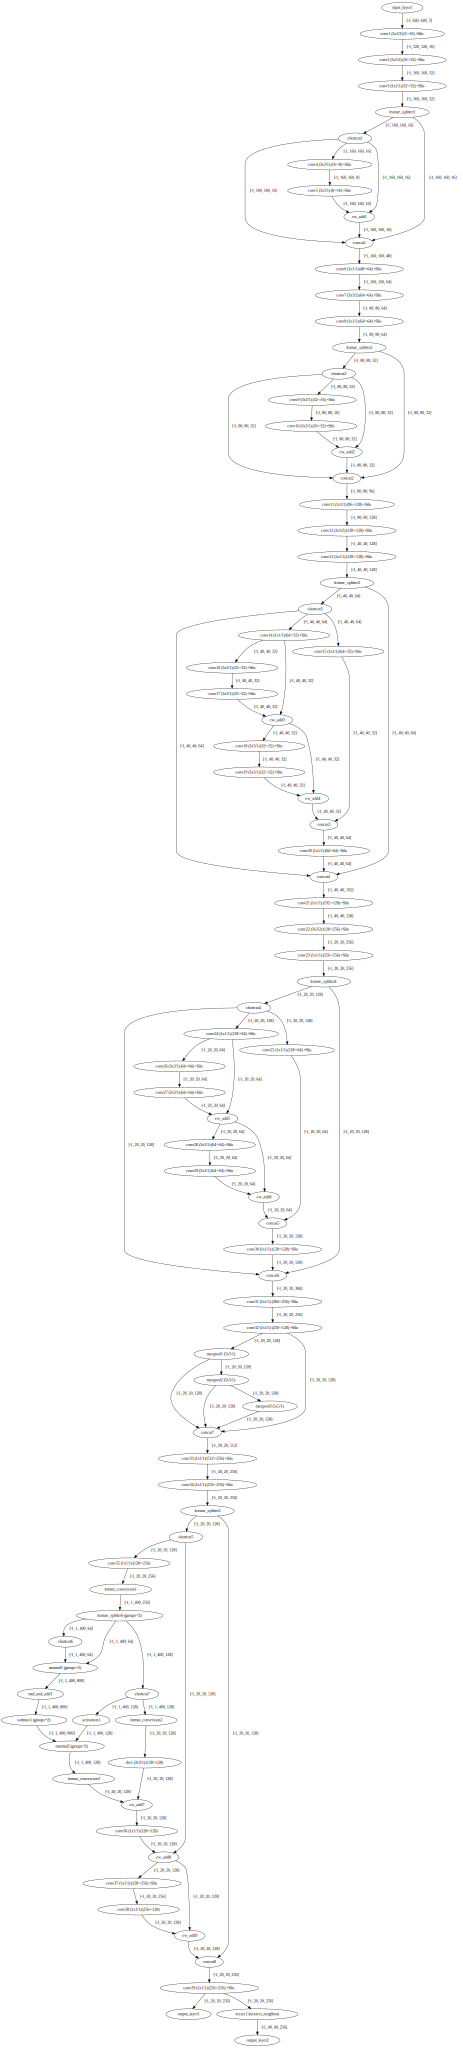

In [7]:
# Use hailo command to parse the model

!hailo visualizer ../models/Chapter5/{onnx_model_name}_hailo_model.har --no-browser
SVG("./yolov11n.svg")


# Step 4: Model Optimization

The input is a HAR file in Hailo Model state (before optimization; with native weights) and the output will be a quantized HAR file with quantized weights.

In [8]:
# General imports used throughout the tutorial
# file operations
import json
import os

import numpy as np
import tensorflow as tf
from IPython.display import SVG
from matplotlib import patches
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow.python.eager.context import eager_mode

# import the hailo sdk client relevant classes
from hailo_sdk_client import ClientRunner, InferenceContext

%matplotlib inline

IMAGES_TO_VISUALIZE = 5

In [9]:
# The folder of images
image_dir = './images'
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Init the list
images = []

# Load every images
for image_file in image_files:
    img_path = os.path.join(image_dir, image_file)
    img = Image.open(img_path).convert('RGB')  # Transform to RGB format
    img_array = np.array(img)  # Transform to NumPy format
    images.append(img_array)

# Transform images to NumPy array
images_array = np.array(images)

In [10]:
# Load our parsed HAR model

assert os.path.isfile(hailo_model_har_name), "Please provide valid path for HAR file"
runner = ClientRunner(har=hailo_model_har_name, hw_arch=chosen_hw_arch)
# By default it uses the hw_arch that is saved on the HAR. For overriding, use the hw_arch flag.

In [11]:
# Call Optimize to perform the optimization process
runner.optimize(images_array)

# Save the result state to a Quantized HAR file
quantized_model_har_path = f"../models/Chapter5/{onnx_model_name}_quantized_model.har"
runner.save_har(quantized_model_har_path)

[info] Starting Model Optimization
[warning] Reducing optimization level to 0 (the accuracy won't be optimized and compression won't be used) because there's less data than the recommended amount (1024), and there's no available GPU
[warning] Running model optimization with zero level of optimization is not recommended for production use and might lead to suboptimal accuracy results
[info] Model received quantization params from the hn
[info] Starting Mixed Precision
[info] Mixed Precision is done (completion time is 00:00:00.32)
[info] Layer Norm Decomposition skipped
[info] Starting Stats Collector
[info] Using dataset with 11 entries for calibration


Calibration:   0%|          | 0/11 [00:00<?, ?entries/s]2024-10-14 17:25:25.708194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-10-14 17:25:25.708355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-10-14 17:25:25.738336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype fl

[info] Stats Collector is done (completion time is 00:00:14.75)
[info] Starting Fix zp_comp Encoding
[info] Fix zp_comp Encoding is done (completion time is 00:00:00.00)
[info] Starting matmul_equalization
[info] matmul_equalization is done (completion time is 00:00:00.00)
[info] activation fitting started for yolov11n/ew_sub_softmax1/act_op
[info] activation fitting started for yolov11n/ne_activation_ew_sub_softmax1/act_op
[info] activation fitting started for yolov11n/reduce_sum_softmax1/act_op
[info] Finetune encoding skipped
[info] Bias Correction skipped
[info] Adaround skipped
[info] Fine Tune skipped
[info] Layer Noise Analysis skipped
[info] Model Optimization is done
[info] Saved HAR to: /home/jiahao/Tutorial-of-AI-Kit-with-Raspberry-Pi-From-Zero-to-Hero/models/Chapter5/yolov11n_quantized_model.har


# Step 5: Compile Hailo Archive Quantized Model to HEF

In [12]:
runner = ClientRunner(har=quantized_model_har_path, hw_arch=chosen_hw_arch)

In [13]:
hef = runner.compile()

file_name = f"../models/Chapter5/{onnx_model_name}.hef"

with open(file_name, "wb") as f:
    f.write(hef)

[info] To achieve optimal performance, set the compiler_optimization_level to "max" by adding performance_param(compiler_optimization_level=max) to the model script. Note that this may increase compilation time.
[info] Loading network parameters
[info] Starting Hailo allocation and compilation flow
[info] Finding the best partition to contexts...
[info] Iteration #1 - Contexts: 2
[info] Iteration #2 - Contexts: 2
[info] Iteration #3 - Contexts: 2
[info] Iteration #4 - Contexts: 2
[info] Iteration #5 - Contexts: 2
[info] Iteration #6 - Contexts: 2
[info] Iteration #7 - Contexts: 2
[info] Iteration #8 - Contexts: 3
[info] Iteration #9 - Contexts: 3
[info] Iteration #10 - Contexts: 3
[info] Iteration #11 - Contexts: 3
[info] Iteration #12 - Contexts: 3
[info] Iteration #13 - Contexts: 3
[info] Iteration #14 - Contexts: 3
[info] Iteration #15 - Contexts: 3
[info] Iteration #16 - Contexts: 3
[info] Iteration #17 - Contexts: 3
[info] Iteration #18 - Contexts: 3
[info] Iteration #19 - Context